In [2]:
import scipy.io
import numpy as np
from utils import load_files, get_rdms, get_rdm, get_spearmanr, inter_intra_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import imageio
import torch
%load_ext autoreload
%autoreload 2

In [32]:
%store -r sclip_img_rdms
%store -r tclip_img_rdms
%store -r sclip_random_img_rdms
%store -r sclip_txt_rdms
%store -r sclip_random_txt_rdms

%store -r salbef_img_rdms
%store -r salbef_random_img_rdms
%store -r salbef_txt_rdms
%store -r salbef_random_txt_rdms
%store -r salbef_multi_rdms
%store -r salbef_random_multi_rdms

%store -r svilt_rdms
%store -r svilt_random_rdms

%store -r sgpt_rdms
%store -r svit_rdms
%store -r sbert_txt_rdms

%store -r avg

In [33]:
all_data = avg | sclip_img_rdms | sclip_txt_rdms | svilt_rdms | salbef_img_rdms | salbef_multi_rdms | salbef_txt_rdms | sbert_txt_rdms | svit_rdms | sgpt_rdms 

In [34]:
_, all_res = get_spearmanr(all_data)
df = pd.DataFrame(all_res)

In [38]:
models = ["CLIP Text", "CLIP Image", "VILT", "ALBEF Multi", "ALBEF Image", "ALBEF Text", "Bert Text", "Vit", "GPT"]
# Gets top 2 "performers" of every model for every brain region (to save space on the plot)
d_all = {}
for region in list(avg.keys()):
    sorted_ = df[region].sort_values(ascending=False)
    for m in models:
        i = 0
        l = []
        for idx, v in sorted_.items():
            if m in idx:
                i +=1
                if i > 1:
                    l.append(idx)
        sorted_.drop(labels=l, inplace=True)
    d_all[region] = sorted_

In [42]:
def plot_spearmanr(sorted_data, name, ax):
    sorted_data = sorted_data[name]
    y = sorted_data.values[1:]
    y = 1-y
    x = sorted_data.index.values[1:]

    data = {'Category': list(x),
            'Value': list(y)}

    df = pd.DataFrame(data)

    sns.barplot(x='Category', y='Value', data=df, color='white', edgecolor='black', ax=ax)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel(r'$\bf{deviation\ from\ ' + name + r'\ RDM}$' + '\n' + r'$(1-Spearman \ correlation)$')
    ax.text(0, -0.05, 'best', ha='left', va='center', transform=ax.transAxes)
    ax.text(1, -0.05, 'worst', ha='right', va='center', transform=ax.transAxes)
    for index, row in df.iterrows():
        txt = row['Category']
        if 'CLIP Image' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='darkblue')
        elif 'CLIP Text' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='blue')
        elif 'ALBEF Multi' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='red')
        elif 'ALBEF Image' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='darkred')
        elif 'ALBEF Text' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='orange')
        elif 'VILT' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='purple')
        elif 'Bert Text' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='black')
        elif 'Vit' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='limegreen')
        elif 'GPT' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='grey')
        else:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='darkgreen')
    ax.set_title(name, fontsize=20, fontweight='bold')

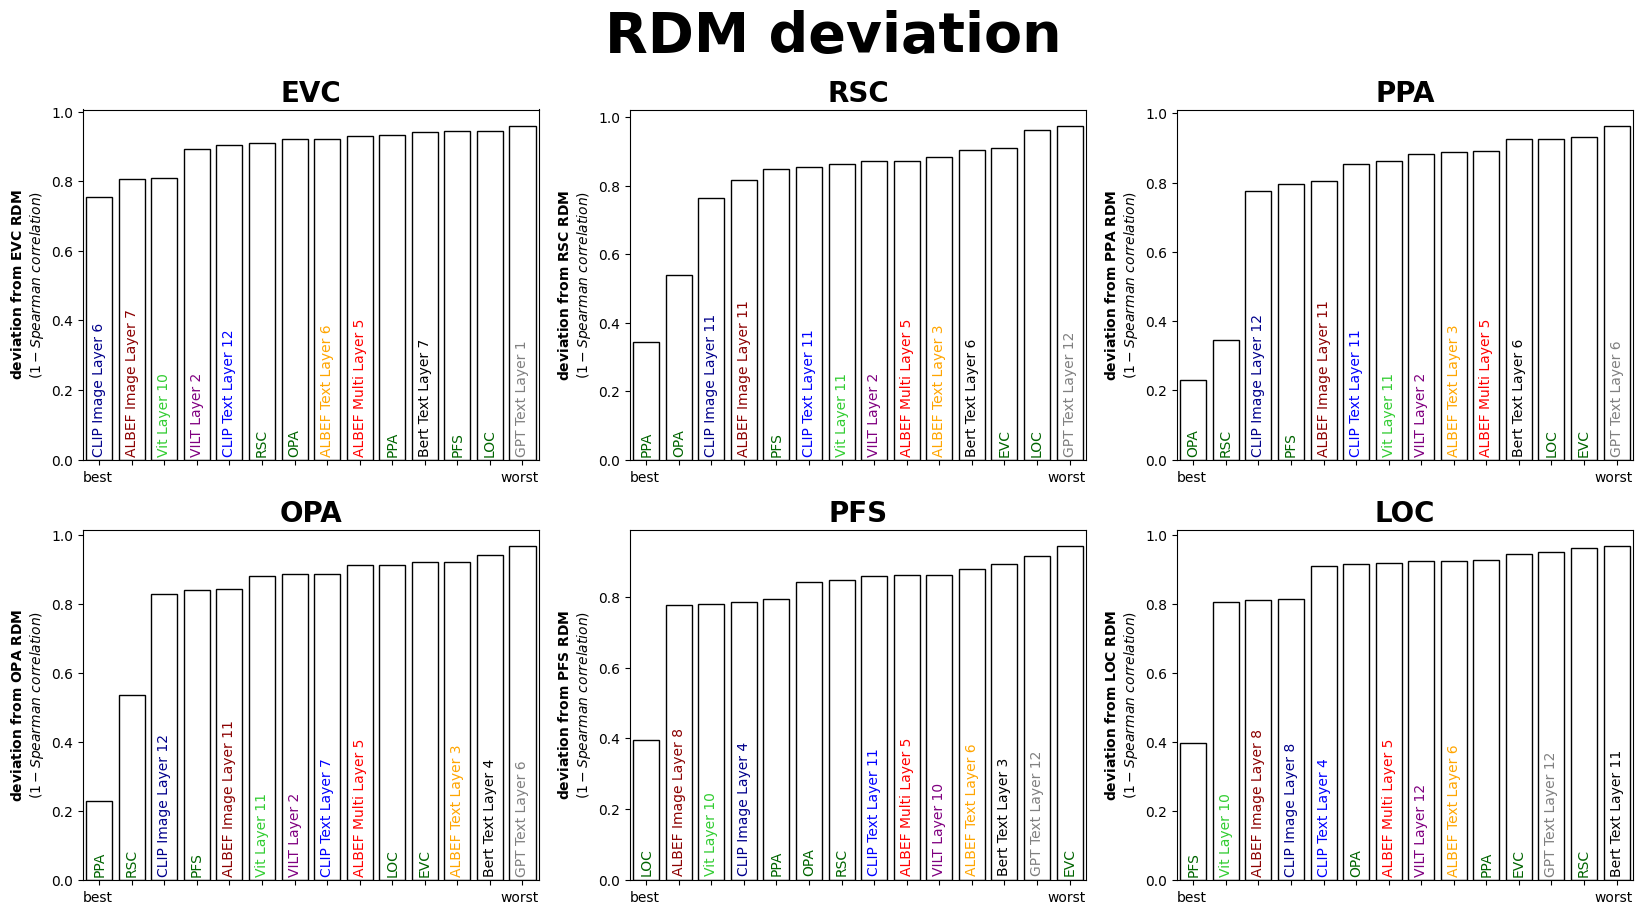

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('RDM deviation', fontsize=40, fontweight='bold')

plot_spearmanr(d_all, 'EVC', axs[0][0])
plot_spearmanr(d_all, 'RSC', axs[0][1])
plot_spearmanr(d_all, 'PPA', axs[0][2])
plot_spearmanr(d_all, 'OPA', axs[1][0])
plot_spearmanr(d_all, 'PFS', axs[1][1])
plot_spearmanr(d_all, 'LOC', axs[1][2])

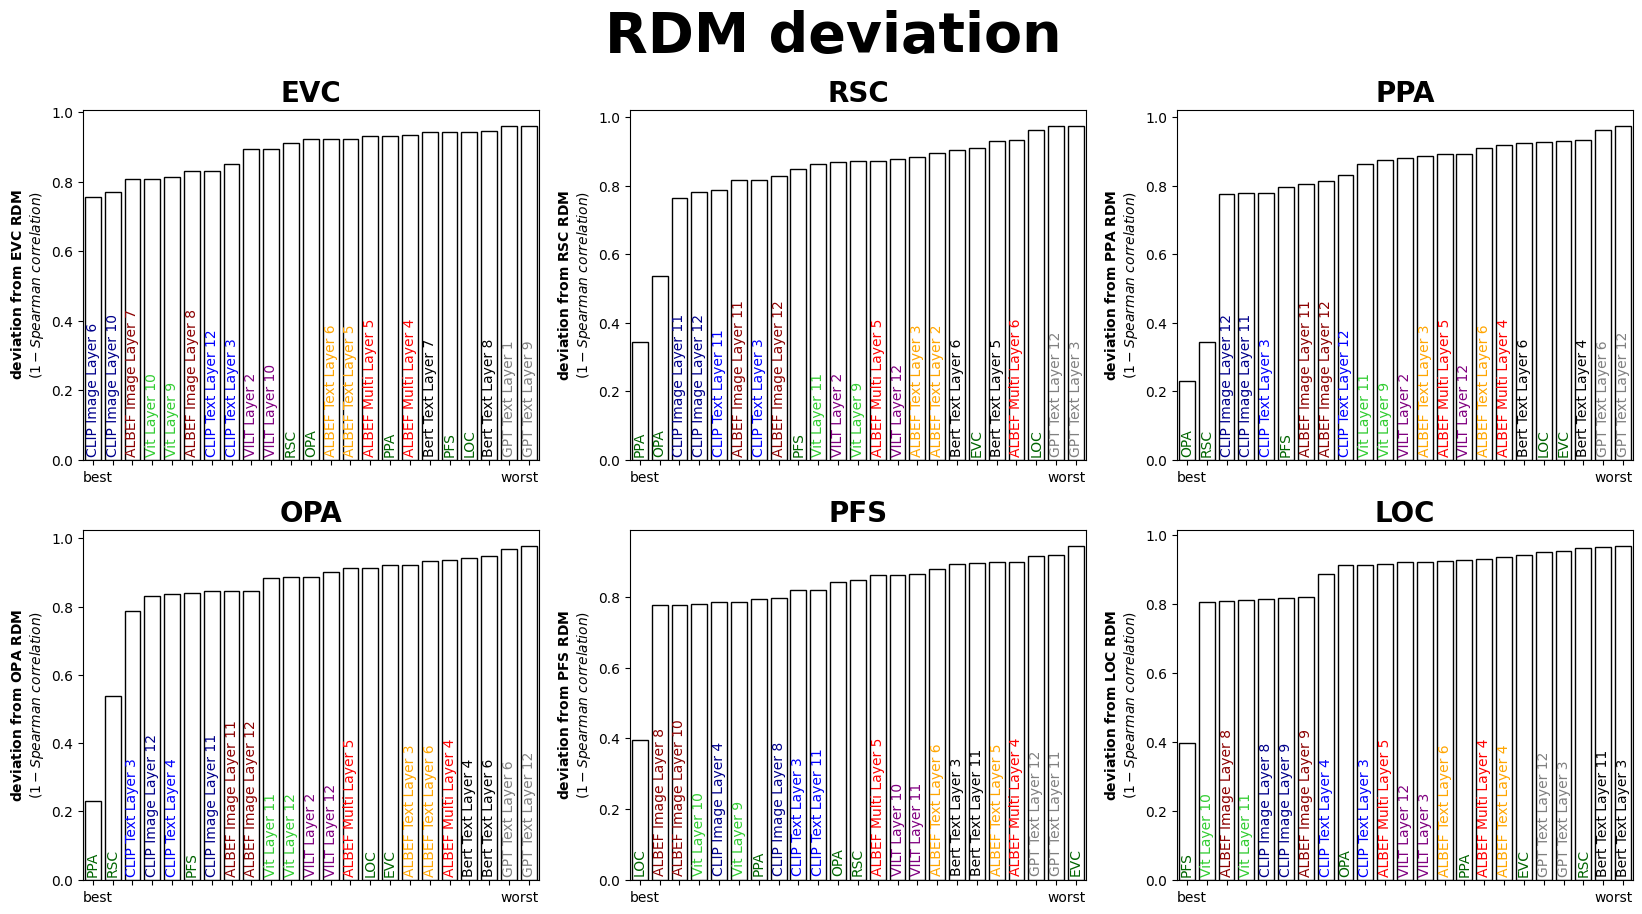

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('RDM deviation', fontsize=40, fontweight='bold')

plot_spearmanr(d_all, 'EVC', axs[0][0])
plot_spearmanr(d_all, 'RSC', axs[0][1])
plot_spearmanr(d_all, 'PPA', axs[0][2])
plot_spearmanr(d_all, 'OPA', axs[1][0])
plot_spearmanr(d_all, 'PFS', axs[1][1])
plot_spearmanr(d_all, 'LOC', axs[1][2])


In [47]:
def compare_to_randomized(avg, df):
    brain_regions = ["EVC", "RSC", "OPA", "PPA", "PFS", "LOC"]
    d = {}
    for region in list(avg.keys()):
        sorted_ = df[region].sort_values(ascending=False)
        sorted_.drop(labels=brain_regions, inplace=True)
        d[region] = sorted_
    for region in list(avg.keys()):
        random_indices = np.array([i for i, label in enumerate(d[region].index) if 'Random' in label])
        non_random_indices = np.array([i for i, label in enumerate(d[region].index) if 'Random' not in label])
        random_max = np.max(d[region][random_indices])
        non_random_max = np.max(d[region][non_random_indices])

        diff = non_random_max - random_max
        print(f"{region}: {diff}")
    return d

In [9]:
def plot_spearmanr_comp(sorted_data, name, ax):
    sorted_data = sorted_data[name]
    y = sorted_data.values
    y = 1-y
    x = sorted_data.index.values

    data = {'Category': list(x),
            'Value': list(y)}

    df = pd.DataFrame(data)

    sns.barplot(x='Category', y='Value', data=df, color='white', edgecolor='black', ax=ax)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel(r'$\bf{deviation\ from\ ' + name + r'\ RDM}$' + '\n' + r'$(1-Spearman \ correlation)$')
    ax.text(0, -0.05, 'best', ha='left', va='center', transform=ax.transAxes)
    ax.text(1, -0.05, 'worst', ha='right', va='center', transform=ax.transAxes)
    for index, row in df.iterrows():
        txt = row['Category']
        if 'Random' in txt:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='darkblue')
        else:
            ax.text(index, 0.01, row['Category'], ha='center', va='bottom', rotation=90, color='darkgreen')
    ax.set_title(name, fontsize=20, fontweight='bold')

In [3]:
clip_img_data = avg | sclip_img_rdms | sclip_random_img_rdms
_, clip_img_res = get_spearmanr(clip_img_data)
df_clip_img = pd.DataFrame(clip_img_res)

In [4]:
clip_txt_data = avg | sclip_txt_rdms | sclip_random_txt_rdms
_, clip_txt_res = get_spearmanr(clip_txt_data)
df_clip_txt = pd.DataFrame(clip_txt_res)

In [5]:
vilt_data = avg | svilt_rdms | svilt_random_rdms
_, vilt_res = get_spearmanr(vilt_data)
df_vilt = pd.DataFrame(vilt_res)

In [6]:
albef_img_data = avg | salbef_img_rdms | salbef_random_img_rdms
_, albef_img_res = get_spearmanr(albef_img_data)
df_albef_img = pd.DataFrame(albef_img_res)

albef_txt_data = avg | salbef_txt_rdms | salbef_random_txt_rdms
_, albef_txt_res = get_spearmanr(albef_txt_data)
df_albef_txt = pd.DataFrame(albef_txt_res)

albef_multi_data = avg | salbef_multi_rdms | salbef_random_multi_rdms
_, albef_multi_res = get_spearmanr(albef_multi_data)
df_albef_multi = pd.DataFrame(albef_multi_res)

EVC: 0.14953302002500585
LOC: 0.13767824538840845
PFS: 0.1581618379452151
OPA: 0.13065212340459947
PPA: 0.13675961310560422
RSC: 0.17538437475436403


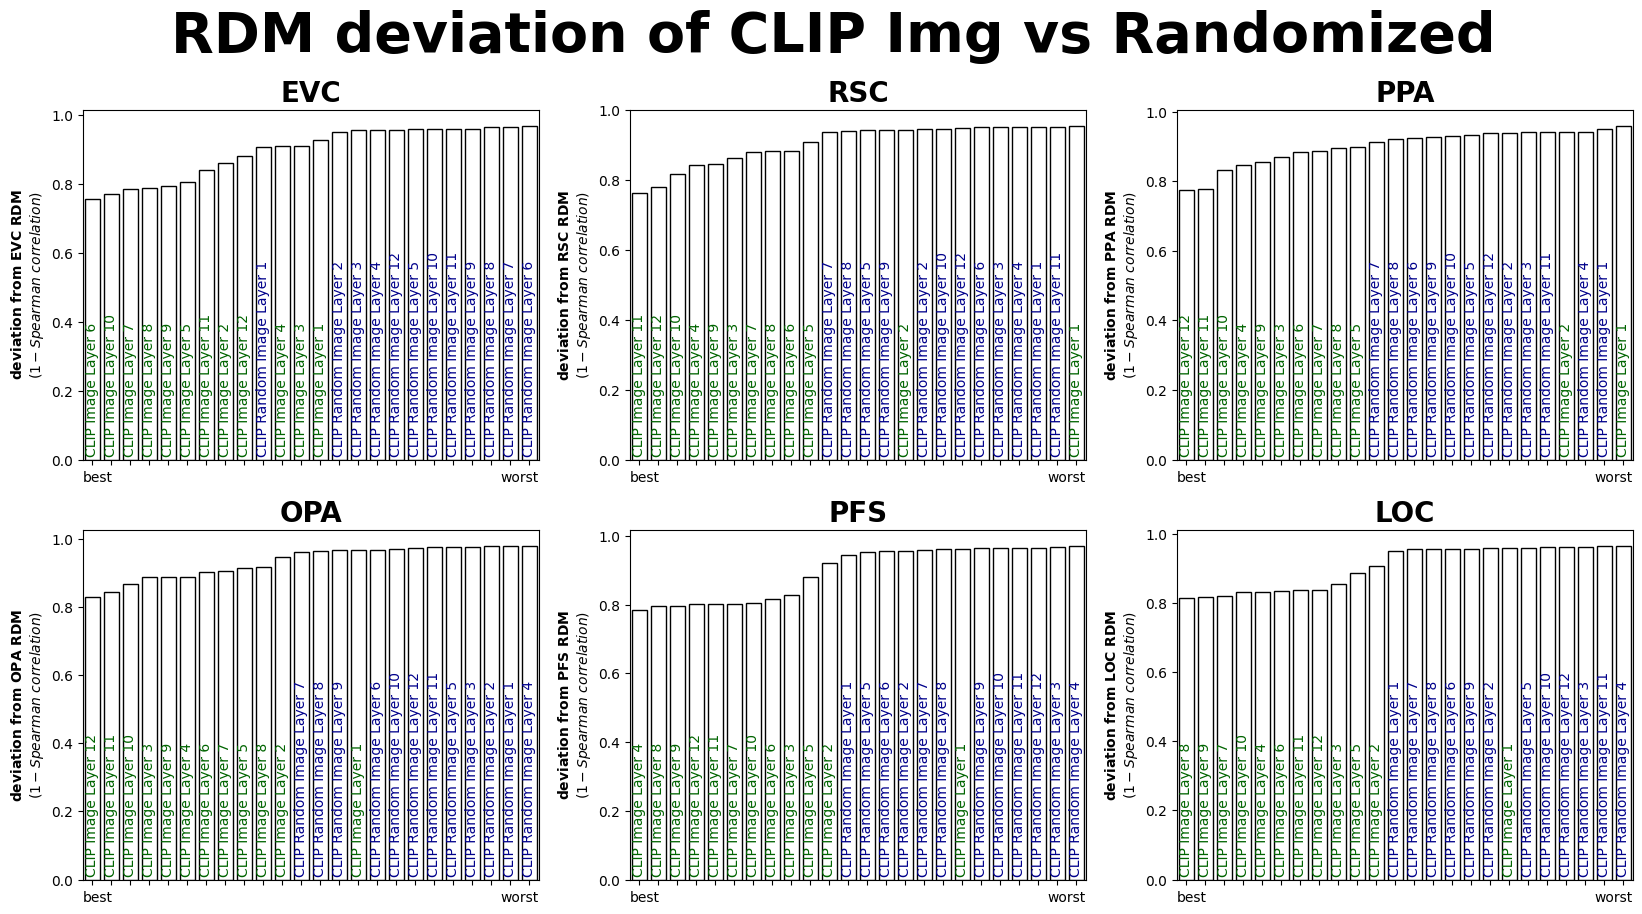

In [48]:
d = compare_to_randomized(avg, df_clip_img)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('RDM deviation of CLIP Img vs Randomized', fontsize=40, fontweight='bold')

plot_spearmanr_comp(d, 'EVC', axs[0][0])
plot_spearmanr_comp(d, 'RSC', axs[0][1])
plot_spearmanr_comp(d, 'PPA', axs[0][2])
plot_spearmanr_comp(d, 'OPA', axs[1][0])
plot_spearmanr_comp(d, 'PFS', axs[1][1])
plot_spearmanr_comp(d, 'LOC', axs[1][2])

EVC: 0.09370519621430332
LOC: 0.08416816426661344
PFS: 0.12086307439338168
OPA: 0.1036399720228089
PPA: 0.13087182725906782
RSC: 0.12517364279273838


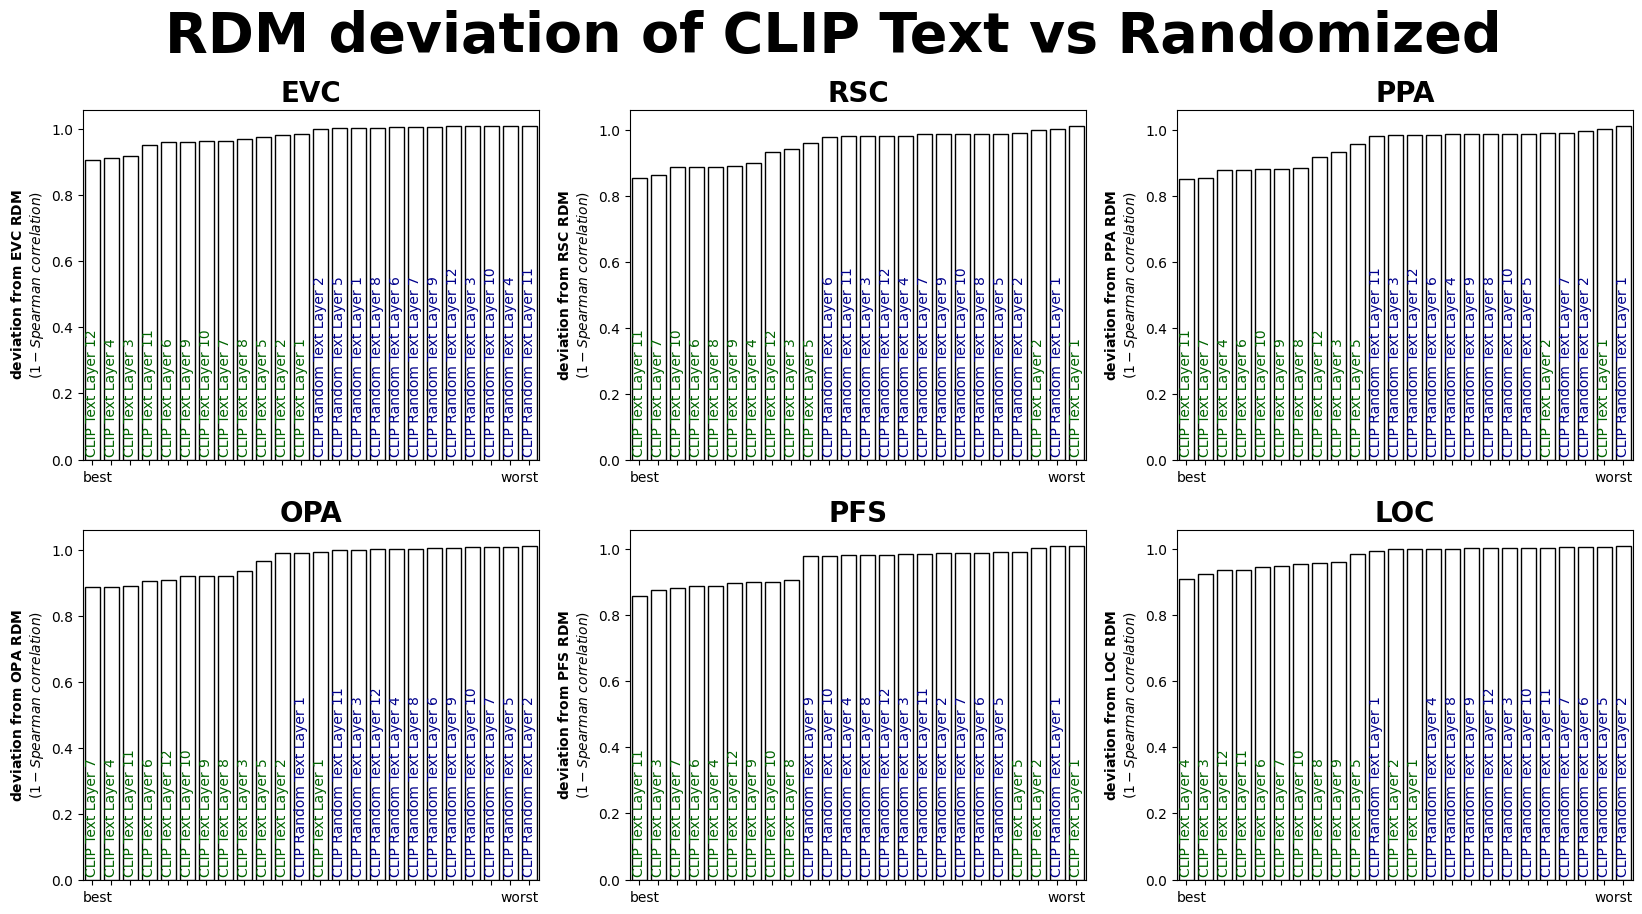

In [49]:
d = compare_to_randomized(avg, df_clip_txt)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('RDM deviation of CLIP Text vs Randomized', fontsize=40, fontweight='bold')

plot_spearmanr_comp(d, 'EVC', axs[0][0])
plot_spearmanr_comp(d, 'RSC', axs[0][1])
plot_spearmanr_comp(d, 'PPA', axs[0][2])
plot_spearmanr_comp(d, 'OPA', axs[1][0])
plot_spearmanr_comp(d, 'PFS', axs[1][1])
plot_spearmanr_comp(d, 'LOC', axs[1][2])

EVC: 0.08818103531561344
LOC: 0.05372489567482156
PFS: 0.10936082057818564
OPA: 0.07356931738320283
PPA: 0.07781139463590851
RSC: 0.09623965124469572


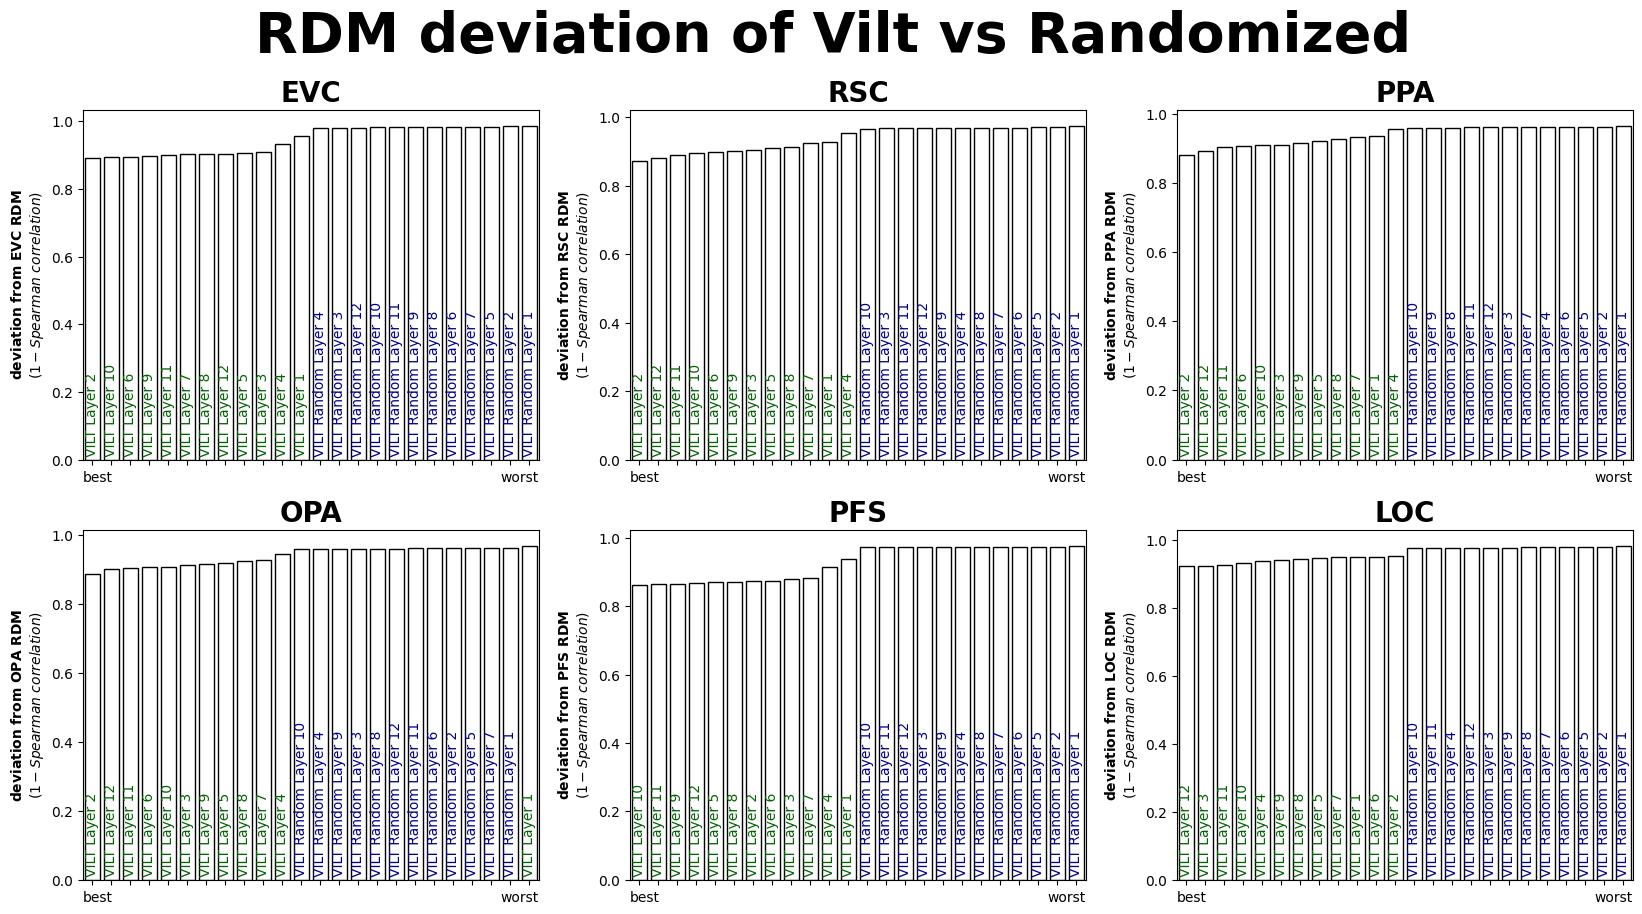

In [50]:
d = compare_to_randomized(avg, df_vilt)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('RDM deviation of Vilt vs Randomized', fontsize=40, fontweight='bold')

plot_spearmanr_comp(d, 'EVC', axs[0][0])
plot_spearmanr_comp(d, 'RSC', axs[0][1])
plot_spearmanr_comp(d, 'PPA', axs[0][2])
plot_spearmanr_comp(d, 'OPA', axs[1][0])
plot_spearmanr_comp(d, 'PFS', axs[1][1])
plot_spearmanr_comp(d, 'LOC', axs[1][2])

EVC: 0.16753314557752508
LOC: 0.16075613593659388
PFS: 0.1868600704683889
OPA: 0.1266535797940646
PPA: 0.17126867631209625
RSC: 0.16905719919242343


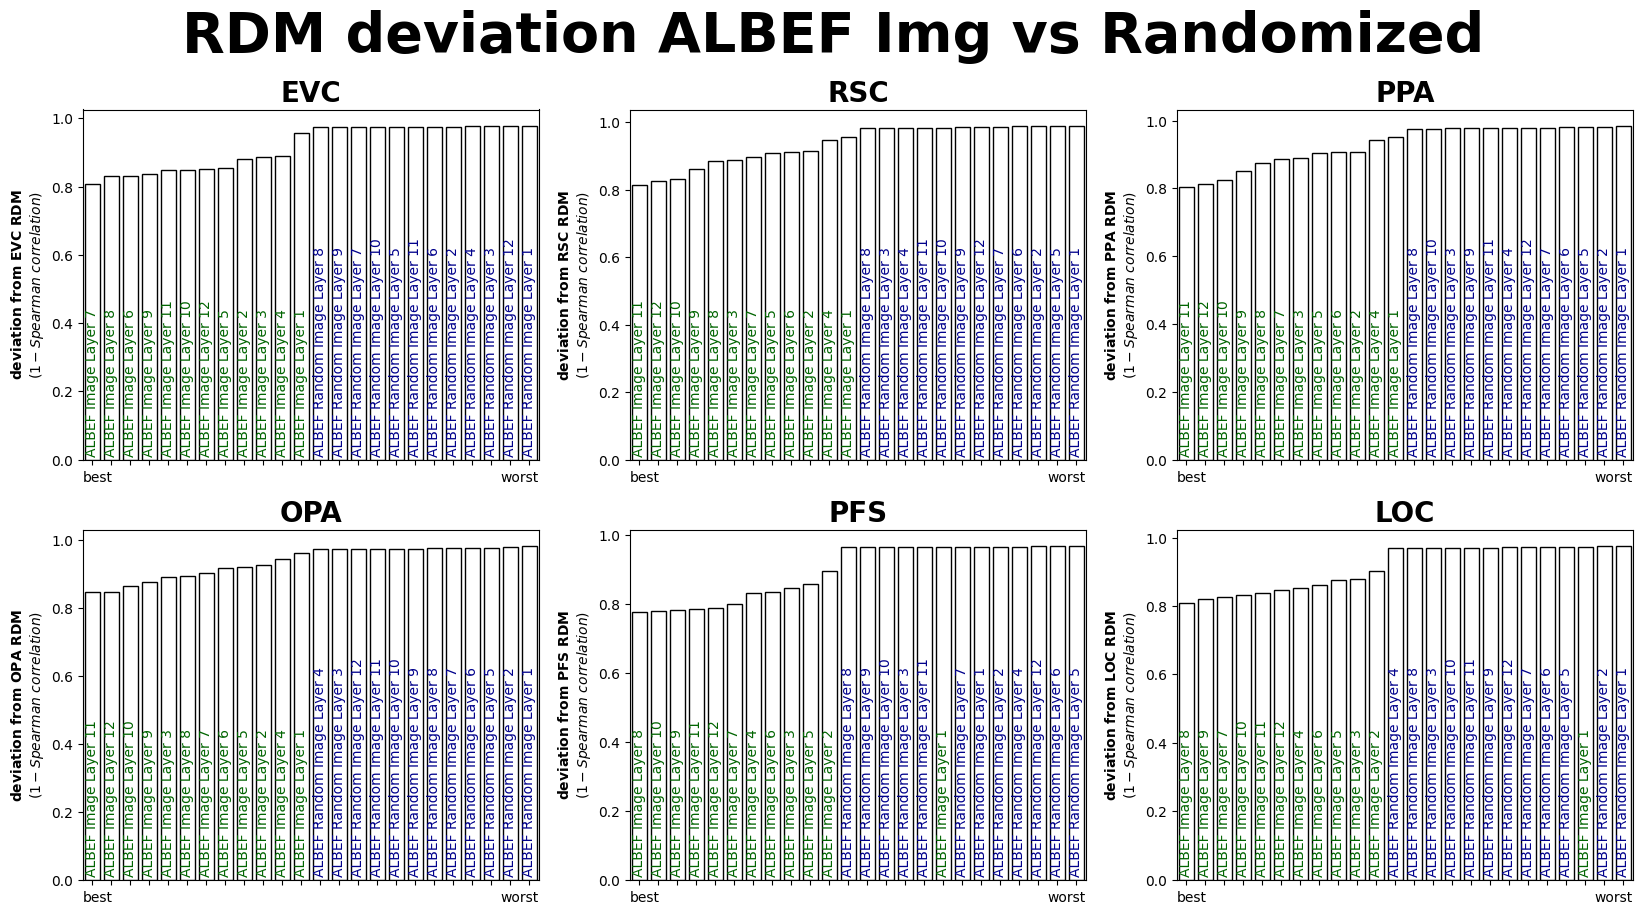

In [51]:
d = compare_to_randomized(avg, df_albef_img)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('RDM deviation ALBEF Img vs Randomized', fontsize=40, fontweight='bold')

plot_spearmanr_comp(d, 'EVC', axs[0][0])
plot_spearmanr_comp(d, 'RSC', axs[0][1])
plot_spearmanr_comp(d, 'PPA', axs[0][2])
plot_spearmanr_comp(d, 'OPA', axs[1][0])
plot_spearmanr_comp(d, 'PFS', axs[1][1])
plot_spearmanr_comp(d, 'LOC', axs[1][2])

EVC: 0.0782918798154949
LOC: 0.0702704272345197
PFS: 0.1267783144895711
OPA: 0.0840107487294811
PPA: 0.116470225097998
RSC: 0.11422197307883171


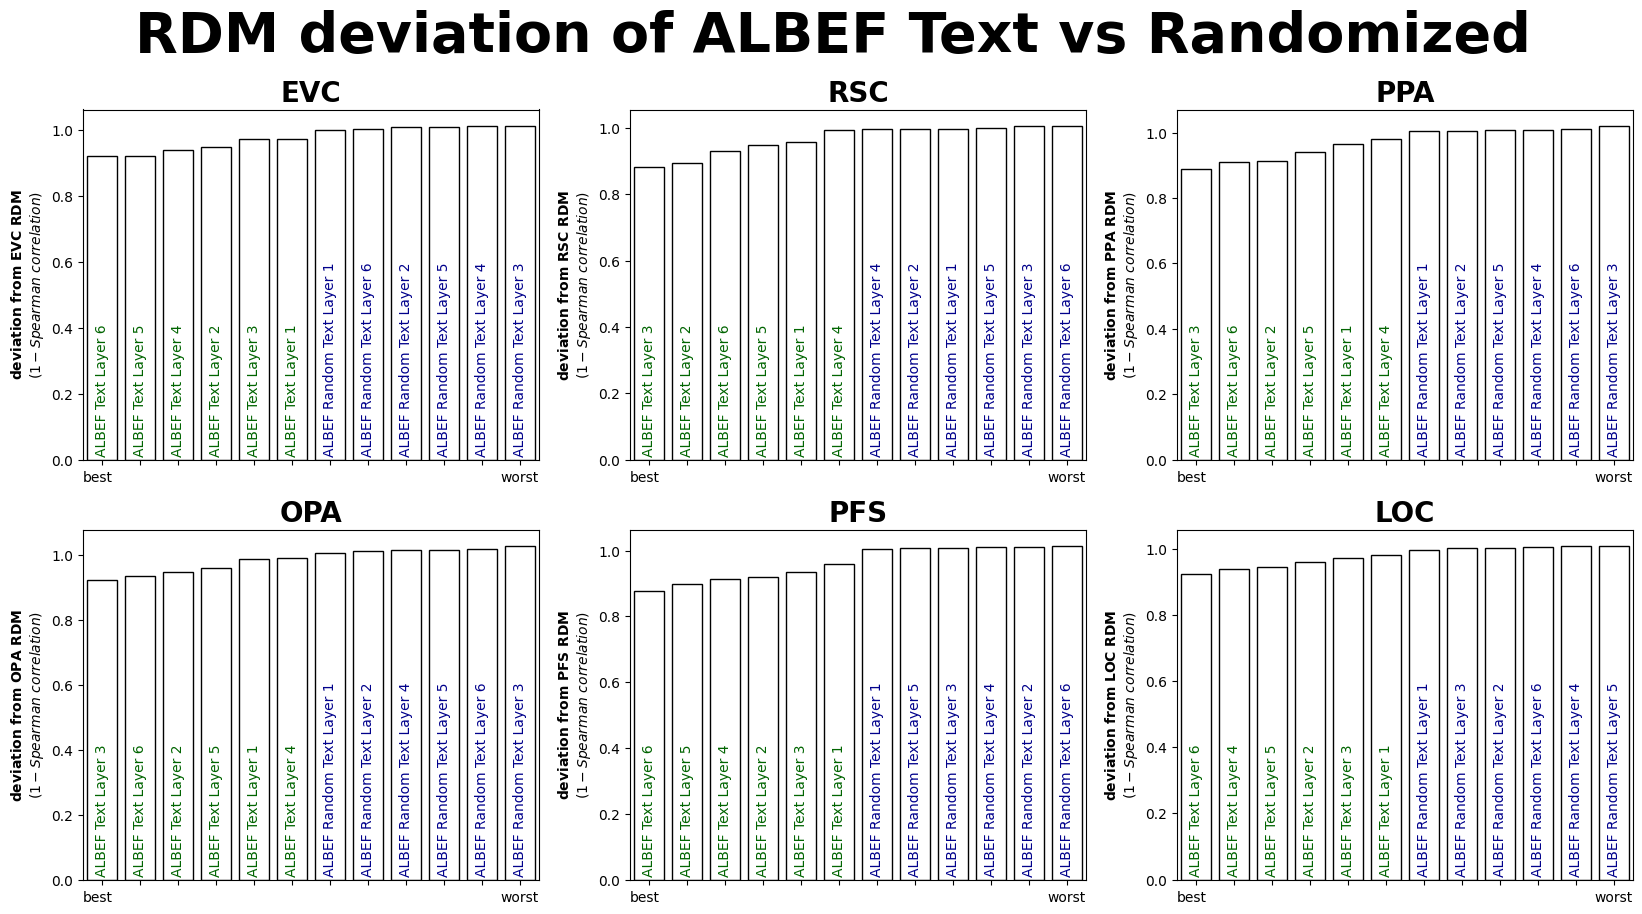

In [52]:
d = compare_to_randomized(avg, df_albef_txt)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('RDM deviation of ALBEF Text vs Randomized', fontsize=40, fontweight='bold')

plot_spearmanr_comp(d, 'EVC', axs[0][0])
plot_spearmanr_comp(d, 'RSC', axs[0][1])
plot_spearmanr_comp(d, 'PPA', axs[0][2])
plot_spearmanr_comp(d, 'OPA', axs[1][0])
plot_spearmanr_comp(d, 'PFS', axs[1][1])
plot_spearmanr_comp(d, 'LOC', axs[1][2])

EVC: 0.04946684087087528
LOC: 0.061501665497245825
PFS: 0.11415771041232063
OPA: 0.05221858968082273
PPA: 0.07116921900162335
RSC: 0.09514609254229714


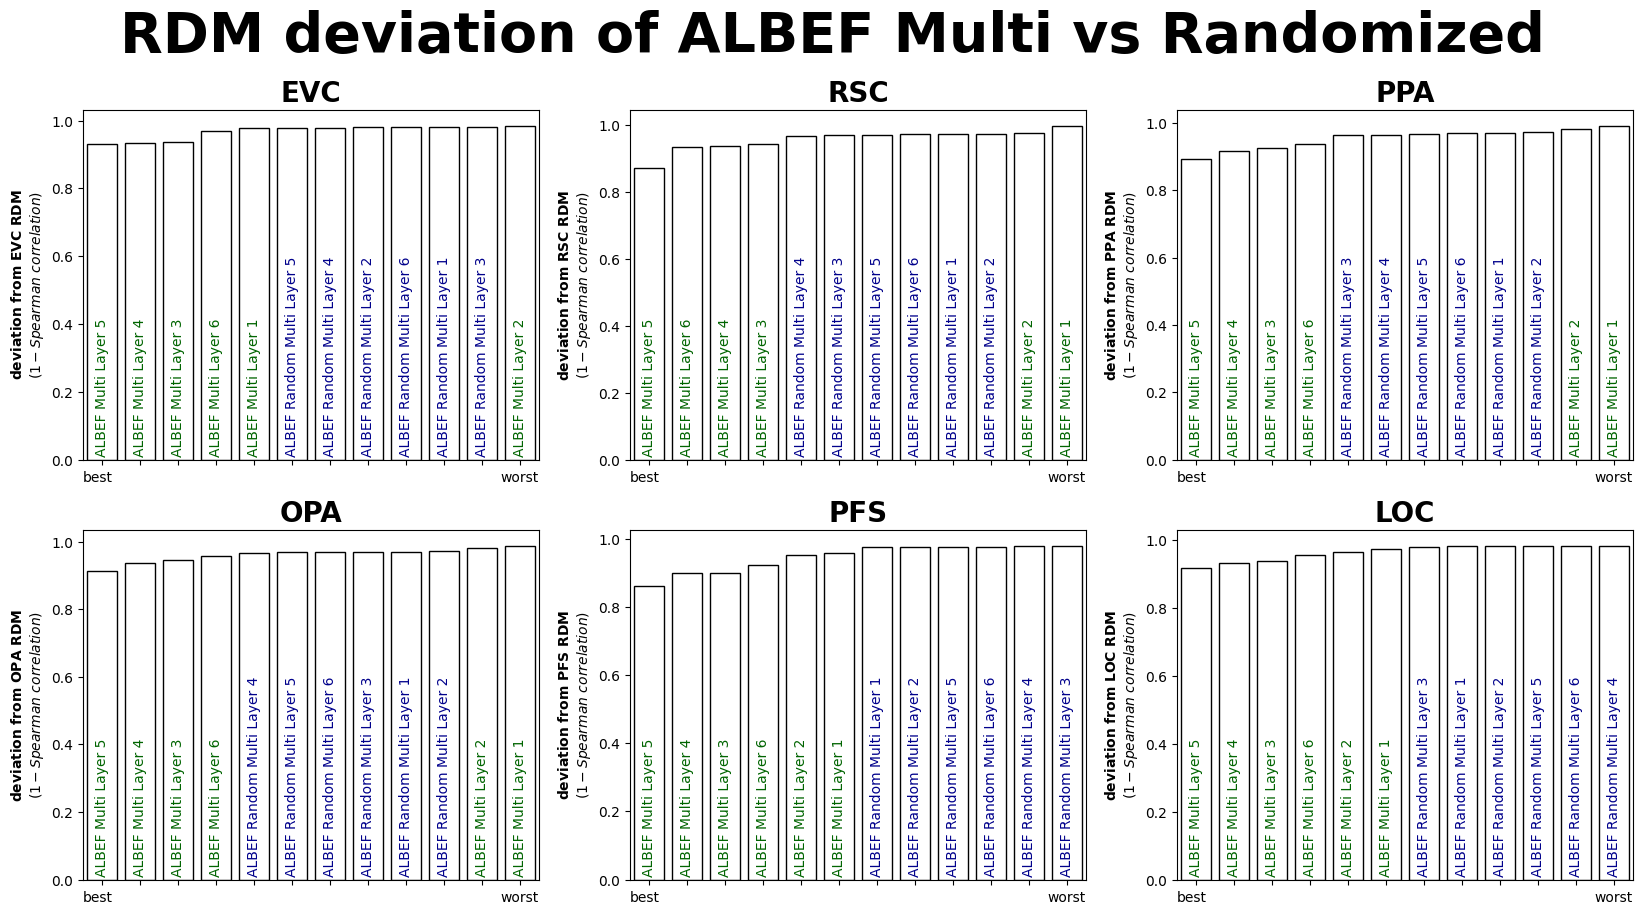

In [53]:
d = compare_to_randomized(avg, df_albef_multi)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
fig.suptitle('RDM deviation of ALBEF Multi vs Randomized', fontsize=40, fontweight='bold')

plot_spearmanr_comp(d, 'EVC', axs[0][0])
plot_spearmanr_comp(d, 'RSC', axs[0][1])
plot_spearmanr_comp(d, 'PPA', axs[0][2])
plot_spearmanr_comp(d, 'OPA', axs[1][0])
plot_spearmanr_comp(d, 'PFS', axs[1][1])
plot_spearmanr_comp(d, 'LOC', axs[1][2])

In [48]:
%store df
%store d_all

Stored 'df' (DataFrame)
Stored 'd_all' (dict)
